# Ejercicio: Redes neuronales y clasificación de enfermedades cardíacas

En este ejercicio entrenaremos una **red neuronal** y varios modelos clásicos de Machine Learning
(Logistic Regression, SVM, Random Forest, Árbol de decisión) para el problema de
**clasificación binaria de enfermedades cardíacas** usando el dataset *Heart Disease*.

Objetivos:

- Cargar y preprocesar el dataset (separar características/target y normalizar).
- Entrenar modelos clásicos de clasificación (LogisticRegression, SVC, RandomForest, DecisionTree).
- Definir y entrenar una **red neuronal en Keras**.
- Comparar el rendimiento de los modelos usando accuracy y matrices de confusión.



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import keras
import kagglehub

print("Versión de Keras / TF:", keras.__version__)
print("Versión de KaggleHub:", kagglehub.__version__)

c:\Users\Usuario\Desktop\Guia redes neuronales\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de Keras / TF: 3.12.0
Versión de KaggleHub: 0.3.13


In [12]:
# Descargar el dataset desde Kaggle usando kagglehub
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
print("Carpeta donde se descargó el dataset:", path)

# Ver qué archivos hay en esa carpeta
print("\nArchivos encontrados:")
print(os.listdir(path))


100%|██████████| 6.18k/6.18k [00:00<00:00, 837kB/s]

Extracting files...
Carpeta donde se descargó el dataset: C:\Users\Usuario\.cache\kagglehub\datasets\johnsmith88\heart-disease-dataset\versions\2

Archivos encontrados:
['heart.csv']


In [13]:
# Buscar el primer archivo .csv en la carpeta descargada
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
print("Archivos CSV encontrados:", csv_files)

if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo .csv en la carpeta del dataset.")

# Tomamos el primero (si solo hay uno) o cambia el índice si quieres otro
csv_name = csv_files[0]
file_path = os.path.join(path, csv_name)

print("Usando este archivo CSV:", file_path)

# Cargar dataset
df = pd.read_csv(file_path)

print("Forma del dataset (filas, columnas):", df.shape)
print("\nPrimeras filas del dataset:")
display(df.head())

print("\nNombres de las columnas:")
print(df.columns)

target_col = "target"  # ajusta esto si tu CSV usa otro nombre para la columna objetivo

print(f"\nDistribución de la variable objetivo ({target_col}):")
print(df[target_col].value_counts())

print("\nValores nulos por columna:")
print(df.isna().sum())


Archivos CSV encontrados: ['heart.csv']
Usando este archivo CSV: C:\Users\Usuario\.cache\kagglehub\datasets\johnsmith88\heart-disease-dataset\versions\2\heart.csv
Forma del dataset (filas, columnas): (1025, 14)

Primeras filas del dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Nombres de las columnas:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

Distribución de la variable objetivo (target):
target
1    526
0    499
Name: count, dtype: int64

Valores nulos por columna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [14]:
# Separar características (X) y objetivo (y)
X = df.drop(columns=[target_col]).copy()
y = df[target_col].values

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Quedarnos con columnas numéricas (por si hubiera alguna no numérica)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols]

print("\nColumnas numéricas usadas como features:")
print(num_cols)

# Rellenar valores faltantes con la media de cada columna
X = X.fillna(X.mean())

# División train / test
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTamaños de los conjuntos:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
print("\nDimensión de entrada para la red neuronal:", input_dim)


Forma de X: (1025, 13)
Forma de y: (1025,)

Columnas numéricas usadas como features:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Tamaños de los conjuntos:
X_train: (820, 13) y_train: (820,)
X_test: (205, 13) y_test: (205,)

Dimensión de entrada para la red neuronal: 13


In [15]:
# Modelos clásicos
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVC": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

resultados_clasicos = {}

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    resultados_clasicos[nombre] = acc
    print(f"Accuracy en test: {acc:.4f}")



Entrenando modelo: LogisticRegression
Accuracy en test: 0.8098

Entrenando modelo: SVC
Accuracy en test: 0.9268

Entrenando modelo: RandomForest
Accuracy en test: 1.0000

Entrenando modelo: DecisionTree
Accuracy en test: 0.9854


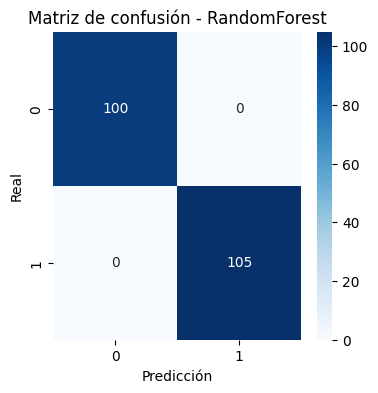


Reporte de clasificación - RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [16]:
# Elegir un modelo para ver la matriz de confusión (por ejemplo, RandomForest)
modelo_ref = modelos["RandomForest"]
y_pred_rf = modelo_ref.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RandomForest")
plt.show()

print("\nReporte de clasificación - RandomForest:")
print(classification_report(y_test, y_pred_rf))


In [17]:
def construir_modelo(input_dim: int):
    modelo = keras.models.Sequential([
        keras.layers.Dense(16, activation="relu", input_shape=(input_dim,)),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    return modelo

modelo_nn = construir_modelo(input_dim)
modelo_nn.summary()


c:\Users\Usuario\Desktop\Guia redes neuronales\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compilar modelo
modelo_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Entrenar
historia = modelo_nn.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # pon 1 si quieres ver el progreso por época
)

# Evaluar en el conjunto de prueba
loss_test, acc_test = modelo_nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss en test: {loss_test:.4f}")
print(f"Accuracy en test: {acc_test:.4f}")


Loss en test: 0.2066
Accuracy en test: 0.9317


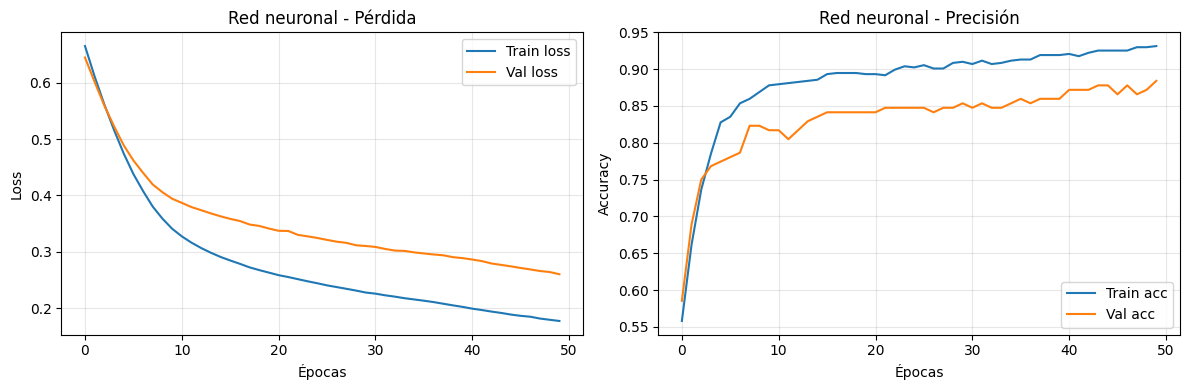

In [19]:
# Curvas de entrenamiento

plt.figure(figsize=(12,4))

# Pérdida
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Train loss")
plt.plot(historia.history["val_loss"], label="Val loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Red neuronal - Pérdida")
plt.legend()
plt.grid(True, alpha=0.3)

# Precisión
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Train acc")
plt.plot(historia.history["val_accuracy"], label="Val acc")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Red neuronal - Precisión")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Comparación de resultados

- **Modelos clásicos**: se entrenaron LogisticRegression, SVC, RandomForest y DecisionTree
  usando los datos normalizados.
- **Red neuronal (Keras)**: se entrenó una red simple con dos capas ocultas.

A partir de las métricas de *accuracy* en el conjunto de prueba y de las matrices de confusión, se puede:

- Comparar qué modelo obtiene mayor precisión.
- Analizar si la red neuronal aporta alguna mejora frente a los modelos clásicos.
- Comentar posibles mejoras (ajuste de hiperparámetros, más capas/neuronas, regularización, etc.).
